---
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Cátedra de Investigación Operativa__\
__Autor: Rodrigo Maranzana__, Rmaranzana@frba.utn.edu.ar

---

# Ejemplo de optimización no lineal

Ejemplo de optimización de problema con curva precio-demanda, corresponde a un modelo NLP box-constrained.

In [2]:
from scipy.optimize import minimize

Parámetros del problema.

In [20]:
# Parámetros
## Demanda:
region1 = {"low": 40, "med": 31, "high": 25}
region2 = {"low": 33, "med": 28, "high": 13}
region3 = {"low": 22, "med": 16, "high": 10}

## Precio:
p = [5.20, 5.45, 5.74]

## Costo:
cv = 4.23

regiones = [region1, region2, region3]

Construcción de función piecewise precio-demanda por región.

In [21]:
# Función piecewise por region:
def fi(x, region):
    if x <= p[1]:
        return (region["med"] - region["low"]) / (p[1] - p[0]) * (x - p[0]) + region["low"]
    else:
        return (region["high"] - region["med"]) / (p[2] - p[1]) * (x - p[1]) + region["med"]

Construcción de modelo de optimización box constrained y minimización con scipy.optimize

In [22]:
# Función de optimización:
def f(x):
    return - (x - cv) * sum(fi(x, region_i) for region_i in regiones)

# Punto de inicio de búsqueda:
x0 = p[0]

# Optimización:
res = minimize(fun=f, x0=x0, bounds=[(p[0], p[2])])

# Salida:
print(res)

      fun: -93.09612499999997
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.42108548e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([5.30875])


Visualización de óptimo

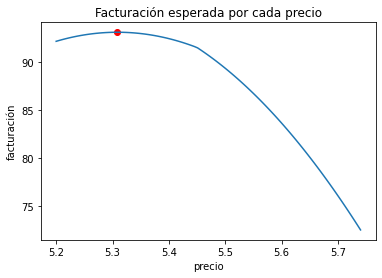

In [23]:
# Ploteo:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(p[0], p[2], 100)

plt.plot(x, [-f(xi) for xi in x])
plt.scatter(res.x, -f(res.x), color="r")
plt.xlabel("precio")
plt.ylabel("facturación")
plt.title("Facturación esperada por cada precio")
plt.show()

# Ejemplo de optimizacion convexa de Floor plan

En este ejemplo aplicamos la librería CVXPY de Python para resolver el caso de floorplanning cuadrático.

Link a libería: https://github.com/cvxpy/cvxpy

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import cvxpy as cp
import numpy as np

(CVXPY) Sep 16 07:36:15 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 16 07:36:15 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Cargamos parámetros y variables

In [3]:
# Parametros
rho = 2.5 # Espacio entre cajas
gamma_max = 5 # Aspect ratio superior
gamma_min = 1/5 # Aspect ratio inferior
Amin = np.array([350., 300., 200., 300., 300.])

# Variables
W = cp.Variable(shape=(1)) # Ancho 
H = cp.Variable(shape=(1)) # Largo
x = cp.Variable(shape=(5)) # Posición x del vértice inferior izquierdo
y = cp.Variable(shape=(5)) # Posición y del vértice inferior izquierdo
w = cp.Variable(shape=(5)) # Ancho de la caja
h = cp.Variable(shape=(5)) # Largo de la caja

Cargamos función objetivo y restricciones

In [4]:
# Indicamos la función objetivo:
objective = cp.Minimize(H + W) # Minimizar perímetro total

# Indicamos las restricciones:
## Restricciones de dependencia entre cajas en x:
constraints = [
    x[0] + w[0] + rho <= x[4],
    x[1] + w[1] + rho <= x[3],
    x[2] + w[2] + rho <= x[3],
    x[3] + w[3] + rho <= x[4],
    x[4] + w[4]       <= W
]

## Restricciones de dependencia entre cajas de y:
constraints += [
    y[2] + h[2] + rho <= y[1],
    y[1] + h[1] + rho <= y[0],
    y[3] + h[3] + rho <= y[0],
    y[0] + h[0] <= H,
    y[4] + h[4] <= H
]

# Restricción de área mínima para cada caja:
constraints.append(cp.log(Amin) <= cp.log(w) + cp.log(h)) 
    
# Restricción de aspect ratio:
constraints.append(h <= cp.multiply(gamma_max, w)) # multiplicacion elemento por elemento
constraints.append(h >= cp.multiply(gamma_min, w)) # multiplicacion elemento por elemento
    
# Restricciones de positividad:
constraints += [
    W >= 0,
    H >= 0,
    x >= 0,
    y >= 0,
    w >= 0,
    h >= 0,
]

Creamos el problema de optimización y resolvemos

In [5]:
# Armamos el problema:
prob = cp.Problem(objective, constraints)

# Resolvemos
result = prob.solve()

# Obtenemos los valores optimos de perímetro y área:
print(f'Perímetro: {2 * prob.value:.2f}')
print(f'Área: {H.value[0] * W.value[0]:.2f}')

Perímetro: 167.96
Área: 1752.59


## Visualización

Utilizamos la librería Matplotlib para visualizar el resultado.

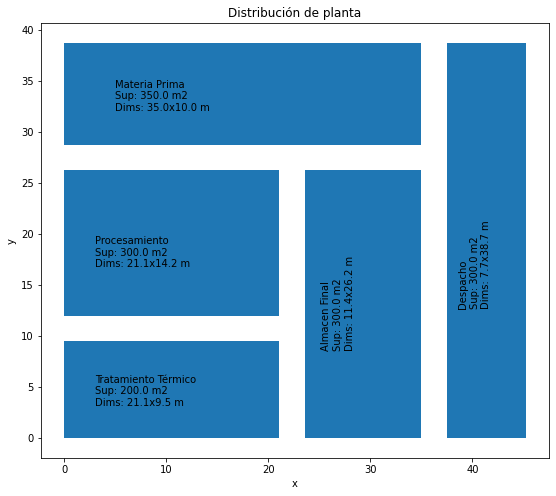

In [6]:
# Ploteamos la solución:
def texto(rotate):
    plt.text(xi+wi/7, yi+hi/3, f"{str(i)}\nSup: {round(wi*hi, 0)} m2\
                \nDims: {round(wi, 1)}x{round(hi, 1)} m", rotation=rotate)

plt.subplots(figsize=(12, 8))

areas = ["Materia Prima", "Procesamiento", "Tratamiento Térmico", "Almacen Final", "Despacho"]
for i, xi, yi, wi, hi in zip(areas, x.value, y.value, w.value, h.value):
    rectangle = pac.Rectangle((xi, yi), wi, hi)
    plt.gca().add_patch(rectangle)
    texto(0) if wi > hi else texto(90)
    
plt.axis('scaled')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribución de planta")
plt.show()

In [72]:
x.value

array([4.11247048e-07, 2.45240181e-07, 3.67542649e-07, 2.35690696e+01,
       3.75057139e+01])